## Clustering of field plots data RS observation
-----

In [5]:
!pip3 -q install seaborn

In [1]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 
from rasterio.mask import mask as crop_mask
import os 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt


import matplotlib.pyplot as plt
import numpy as np
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## 1. Read field-plots data 

In [356]:
fnames = {"invent_plots":"../shape_data/ROI_plots70/ROI_plots70.shp"}

gdf = gpd.read_file(fnames['invent_plots'])

gdf.loc[:, 'key'] = gdf.index

In [357]:
def scale_geom(shape, scale:int):
    return affinity.scale(shape, xfact=scale, yfact=scale, origin='center')
def getRadius(x)->float:
    return np.sqrt(x.area/np.pi)


def generate_NDVI(features):
    nir = features[7]
    red = features[3]
    ndvi = (nir-red)/((nir+red).apply(lambda x: 0.000000001 if x==0 else x))
    return ndvi

def generate_EVI(features):
    evi2 = 2.5*(features[7] - features[3])/((features[7]  + 2.4*features[3] + 1).apply(lambda x: 0.000000001 if x==0 else x))
    return evi2

def generate_NDRE(features):
    ndre = (features[7] - features[4])/((features[7] + features[4]).apply(lambda x: 0.000000001 if x==0 else x))
    return ndre

def generate_MSAVI(features):
    nir = features[7]
    red = features[3]
    msavi=(2*nir + 1 - ((2*nir+1)**2 - 8*(nir-red))**(1/2))/2
    return msavi

def generate_all_indices(df_def):
    df_def_col = list(df_def.columns)
    df_def['ndvi'] = generate_NDVI(df_def)
    df_def['evi'] = generate_EVI(df_def)
    df_def['ndre'] = generate_NDRE(df_def)
    df_def['msavi'] = generate_MSAVI(df_def)
    df_def = df_def.reindex(columns=df_def_col[:-2]+list(df_def.columns[-4:])+df_def_col[-2:])
    return df_def


def get_datetime(fname:str):
    return dt.datetime.strptime(fname.split('.')[0], "%Y-%m-%d")




def plot_RGB_file(fname: str): 
    img = rio.open(fname)

    red = img.read(4)
    green = img.read(3)
    blue = img.read(2)

    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    return rgb_composite_bn

def plot_RGB_matrix(img)->None: 
    red = img[4, ...]
    green = img[3, ...]
    blue = img[2, ...]
    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    plt.imshow(rgb_composite_bn)

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)


def normalize_pixel(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [358]:

class Dataset:
    def __init__(self):
        
        self.path_to_tiff_file = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer.tiff'
        self.dates_images = ['2019-07-01','2019-07-04', '2019-08-03', '2019-08-30',
                         '2020-07-03', '2020-07-05', '2020-07-13', '2020-08-04',
                         '2020-08-12', '2020-08-17', '2019-08-05', '2019-08-15',
                         '2020-08-09', '2019-08-08']
        self.cols = self.get_all_cols()
    def get_all_cols(self):
        col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
        all_cols = []
        for date in sorted(self.dates_images):
            for col in col_names:
                all_cols.append(date+'_'+col)
        return all_cols
    
    def get_svi_cols(self):
        col_names = ["B01","B02","B03","B04","B05","B06","B07","B08",
                     "B8A","B09","B11","B12", "NDVI", "EVI", "MSAVI", "NDRE"] # CLM
        all_cols = []
        for date in sorted(self.dates_images):
            for col in col_names:
                all_cols.append(date+'_'+col)
        return all_cols

    
    def prepare_forest_classes_dataset(self, gdf: gpd.GeoDataFrame)->pd.DataFrame:

        df_indices_field = pd.DataFrame(columns = [*self.cols, "key",  'class'])
        print('Start')
        for invent_plot_data in gdf.iterrows():

            inv_dict = invent_plot_data[1].to_dict()
            print(f"{inv_dict['key'] } ", end=' ')
            df = self.get_bands_by_shape(inv_dict, 1.0)
            df_indices_field = pd.concat([df_indices_field, df])
            
        df_indices_field = self.prepare_SVI(df_indices_field)
        return df_indices_field
    
    def prepare_SVI(self, df:pd.DataFrame)->pd.DataFrame:
        for date in self.dates_images:
            df = self.get_ndvi(df, date)
            df = self.generate_NDRE(df, date)
            df = self.evi(df, date)
            df = self.generate_MSAVI(df, date)
        
        svi_cols = self.get_svi_cols()
        svi_cols.extend(['key', 'class'])
        return df[svi_cols]
        
    def get_bands_by_shape(self, invent_plot_data:dict, scale:float)->pd.DataFrame:
        """
        Get bands from geotiff by polygon mask

        Input: (Polygon) - shape

        Output: (pd.DataFrame) - df with bands, date, class 

        """

        shape = invent_plot_data['geometry']
        shape = scale_geom(shape=shape, scale=scale)
        with rio.open(self.path_to_tiff_file) as src:

            out_image, out_transform = crop_mask(src, 
                                                 [shape],
                                                 all_touched=True,
                                                 crop=True)

            out_meta = src.meta 
            x = out_image[:, ...].reshape(len(self.cols), out_image.shape[1]*out_image.shape[2])
        df = pd.DataFrame(x.T, columns=self.cols)
        mask = df.sum(axis=1)>0
        df = df.loc[mask]
        df.loc[:, 'key'] = invent_plot_data['key']
        df.loc[:, 'class'] = invent_plot_data['t_Class']
        df[self.cols] = normalize_pixel(df[self.cols].values)
        return df
    def get_ndvi(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        ndvi = (nir-red)/((nir+red).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_NDVI"] = ndvi
        return df

    def evi(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        evi2 = 2.5*(nir - red)/((nir+ 2.4*red + 1).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_EVI"] = evi2
        return df

    def generate_NDRE(self, df: pd.DataFrame, date: str):
        red_far = df[f"{date}_B05"]
        nir = df[f"{date}_B08"]
        ndre = (nir - red_far)/((nir + red_far).apply(lambda x: 0.000001 if x==0 else x))
        df.loc[:, f"{date}_NDRE"] = ndre
        return df

    def generate_MSAVI(self, df: pd.DataFrame, date: str):
        red = df[f"{date}_B04"]
        nir = df[f"{date}_B08"]
        msavi=(2*nir + 1 - ((2*nir+1)**2 - 8*(nir-red))**(1/2))/2
        df.loc[:, f"{date}_MSAVI"] = msavi
        return df

In [359]:
mask_forest = gdf['t_Class']<11
forest_gdf = gdf.loc[mask_forest]

In [360]:
dataset = Dataset()
forest = dataset.prepare_forest_classes_dataset(gdf=forest_gdf)

Start
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220 

In [361]:
forest.to_csv('../shape_data/forest_bands.csv')

In [362]:
mask_non_forest = gdf['t_Class']>11
non_forest_gdf = gdf.loc[mask_non_forest]
non_forest = dataset.prepare_forest_classes_dataset(gdf=non_forest_gdf)

Start
224  225  226  227  228  229  

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
non_forest.to_csv('../shape_data/forest_bands.csv')

## 2. EDA

In [350]:
# Fill diagonal and upper half with NaNs
corr = non_forest.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.iloc[::3, ::2]
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/tmp/ipykernel_674/878481204.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr.iloc[::3, ::2]


,2019-07-01_B01,2019-07-01_B03,2019-07-01_B05,2019-07-01_B07,2019-07-01_B8A,2019-07-01_B11,2019-07-01_NDVI,2019-07-01_MSAVI,2019-07-04_B01,2019-07-04_B03,2019-07-04_B05,2019-07-04_B07,2019-07-04_B8A,2019-07-04_B11,2019-07-04_NDVI,2019-07-04_MSAVI,2019-08-03_B01,2019-08-03_B03,2019-08-03_B05,2019-08-03_B07,2019-08-03_B8A,2019-08-03_B11,2019-08-03_NDVI,2019-08-03_MSAVI,2019-08-05_B01,2019-08-05_B03,2019-08-05_B05,2019-08-05_B07,2019-08-05_B8A,2019-08-05_B11,2019-08-05_NDVI,2019-08-05_MSAVI,2019-08-08_B01,2019-08-08_B03,2019-08-08_B05,2019-08-08_B07,2019-08-08_B8A,2019-08-08_B11,2019-08-08_NDVI,2019-08-08_MSAVI,2019-08-15_B01,2019-08-15_B03,2019-08-15_B05,2019-08-15_B07,2019-08-15_B8A,2019-08-15_B11,2019-08-15_NDVI,2019-08-15_MSAVI,2019-08-30_B01,2019-08-30_B03,2019-08-30_B05,2019-08-30_B07,2019-08-30_B8A,2019-08-30_B11


In [353]:
corr_matrix = non_forest.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
non_forest.drop(to_drop, axis=1, inplace=True)

In [355]:
# Fill diagonal and upper half with NaNs
corr = non_forest.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.iloc[:, :]
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

/tmp/ipykernel_674/1738050695.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr.iloc[:, :]


,2019-07-01_B01,2019-07-01_B06,2019-07-01_B09,2019-07-01_EVI,2019-08-03_B06,2019-08-05_B01,2019-08-08_B09,2019-08-15_B01,2019-08-15_B06,2019-08-15_B11,2019-08-15_NDVI,2019-08-30_B06,2019-08-30_NDVI,2019-08-30_EVI,2020-07-03_B06,2020-07-03_EVI,2020-08-04_B01,2020-08-04_B06,2020-08-04_B09,2020-08-04_B11,2020-08-04_NDVI,2020-08-12_B02,2020-08-17_EVI
2019-07-01_B01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-07-01_B06,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-07-01_B09,-0.05,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-07-01_EVI,-0.65,0.69,0.61,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-03_B06,-0.30,0.83,0.80,0.72,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-05_B01,0.81,-0.27,-0.29,-0.62,-0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-08_B09,0.05,0.72,0.86,0.42,0.81,-0.22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-15_B01,-0.59,-0.22,-0.20,0.34,-0.18,-0.20,-0.36,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-15_B06,-0.77,0.12,0.19,0.65,0.34,-0.53,0.11,0.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2019-08-15_B11,0.51,0.09,-0.01,-0.23,-0.13,0.51,0.01,0.03,-0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 3. Plotting


In [ ]:
path='/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/'
list_of_geotiff = [tiff for tiff in os.listdir(path) if 'tiff' in tiff]
mask = (df_indices_field['date'].dt.month>6) & (df_indices_field['date'].dt.month<9)
dates_images = df_indices_field.loc[mask, 'date'].unique()
dates_images = [str(image)[:10] for image in dates_images]

In [148]:
src = rio.open(path_to_tiff_file)

In [150]:
X = src.read(1)

In [153]:
def normalize(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [162]:
X = normalize(124)

In [220]:
for x in sorted(dates_images):
    print(x+'.tiff ', end='')

2019-07-01.tiff 2019-07-04.tiff 2019-08-03.tiff 2019-08-05.tiff 2019-08-08.tiff 2019-08-15.tiff 2019-08-30.tiff 2020-07-03.tiff 2020-07-05.tiff 2020-07-13.tiff 2020-08-04.tiff 2020-08-09.tiff 2020-08-12.tiff 2020-08-17.tiff 

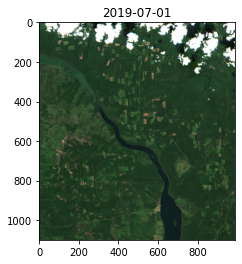

In [147]:
for tiff_file in sorted(dates_images):
    path_to_tiff_file = os.path.join(path, tiff_file+'.tiff')
    print()
    rgb_composite_bn = plot_RGB_file(path_to_tiff_file)
    plt.imshow(rgb_composite_bn[::3, ::3, :])
    plt.title(tiff_file.split('.')[0])
    plt.show()
    break

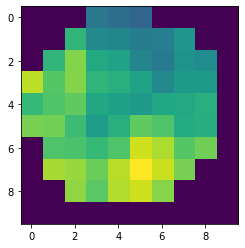

In [73]:
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
plt.imshow(out_image[3,...])

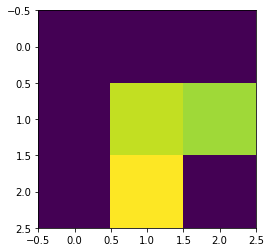

In [75]:
shape = gdf_8m.iloc[0,-1]
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df

plt.imshow(out_image[3,...])

In [16]:
gdf_8m.crs

<Derived Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich